In [1]:
## todo
# README.md : loss, activation, optimizer, initializer, Dense layer, Covolution layer, Pooling layer, Flatten layer
# optimizer : learning rate scheduler, gradient clipping
# layer : rnn, dropout, batch normalization
# analysis : validation error
# fit : callbacks
# logistic regression : softmax, bce, cce

# tf -> custom calcuration program
# validation code

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
class Acitvations:
    class Sigmoid:
        def forward(self, data):
            return tf.math.divide(1, (1 + tf.math.exp(-data)))

        def backward(self, gradients, inputs, outputs):
            activation_gradients = tf.math.multiply(outputs, tf.math.subtract(1, outputs))
            return tf.math.multiply(gradients, activation_gradients)

    class ReLU:
        def forward(self, data):
            return tf.math.maximum(0, data)

        def backward(self, gradients, inputs, outputs):
            activation_gradients = tf.math.divide(outputs, inputs+1e-7)
            return tf.math.multiply(gradients, activation_gradients)

    class Linear:
        def forward(self, data):
            return data

        def backward(self, gradients, inputs, outputs):
            return gradients

    class Softmax:
        def forward(self, data):
            e_x = tf.math.exp(data - tf.math.reduce_max(data))
            return e_x / tf.math.reduce_sum(e_x, axis=1, keepdims=True)

        def backward(self, gradients, inputs, outputs):
            reshaped_outputs = tf.expand_dims(outputs, axis=-1)
            outer_outputs = tf.matmul(reshaped_outputs, tf.transpose(reshaped_outputs, [0, 2, 1]))
            activation_gradients = tf.linalg.diag(outputs) - outer_outputs
            return tf.reduce_sum(activation_gradients * tf.expand_dims(gradients, axis=-1), axis=1)

    class Tanh:
        def forward(self, data):
            return tf.math.exp(data) - tf.math.exp(-data) / tf.math.exp(data) + tf.math.exp(-data)

        def backward(self, gradients, inputs, outputs):
            activation_gradients = 1 - tf.math.pow(outputs, 2)
            return tf.math.multiply(activation_gradients, gradients)

In [4]:
class Losses:
    epsilon = 1e-10

    def __new__(self, name):
        function_map = {'mse' : self.MeanSquaredError, 'meansquarederror' : self.MeanSquaredError,
                        'bce' : self.BinaryCrossEntropy, 'binarycrossentropy' : self.BinaryCrossEntropy,
                        'cce' : self.CategoricalCrossEntropy, 'categoricalcrossentropy' : self.CategoricalCrossEntropy}

        return function_map[name.lower()]()

    class MeanSquaredError:
        def forward(self, true, pred):
            return tf.math.reduce_mean(tf.math.pow(pred - true, 2))

        def backward(self, true, pred):
            return 2*(pred - true)

    class BinaryCrossEntropy:
        def forward(self, true, pred):
            pred = tf.clip_by_value(pred, Losses.epsilon, 1-Losses.epsilon)
            return true * tf.math.log(pred) + (1-true) * tf.math.log(1-pred)

        def backward(self, true, pred):
            pred += Losses.epsilon
            return -tf.math.subtract(true / pred, (1-true) / (1-pred))

    class CategoricalCrossEntropy:
        def forward(self, true, pred):
            pred = tf.clip_by_value(pred, Losses.epsilon, 1-Losses.epsilon)
            return -tf.math.reduce_mean(true * tf.math.log(pred))

        def backward(self, true, pred):
            return -tf.math.divide(true, pred+Losses.epsilon)

In [5]:
class Optimizers:
    class SGD:
        def __init__(self, **kwargs):
            self.learning_rate = kwargs.get('learning_rate', 1e-4)

        def update(self, params, gradients):
            for i in range(len(params)):
                params[i].assign_sub(self.learning_rate * gradients[i])

            return params

    class Momentum:
        def __init__(self, **kwargs):
            self.learning_rate = kwargs.get('learning_rate', 1e-4)
            self.decay_rate = kwargs.get('decay_rate', 0.9)
            self.accumulated = None

        def update(self, params, gradients):
            if self.accumulated is None:
                self.accumulated = [0] * len(params)

            for i in range(len(params)):
                self.accumulated[i] = self.decay_rate * self.accumulated[i] + self.learning_rate * gradients[i]
                params[i].assign_sub(self.accumulated[i])

            return params

    class Adagrad:
        def __init__(self, **kwargs):
            self.learning_rate = kwargs.get('learning_rate', 1e-3)
            self.epsilon = kwargs.get('epsilon', 1e-8)
            self.accumulated = None

        def update(self, params, gradients):
            if self.accumulated is None:
                self.accumulated = [0] * len(params)
            
            for i in range(len(params)):
                self.accumulated[i] += tf.math.pow(gradients[i], 2)
                params[i].assign_sub(self.learning_rate * gradients[i] / (self.epsilon + tf.math.sqrt(self.accumulated[i])))

            return params

    class RMSprop:
        def __init__(self, **kwargs):
            self.learning_rate = kwargs.get('learning_rate', 1e-4)
            self.decay_rate = kwargs.get('decay_rate', 0.9)
            self.epsilon = kwargs.get('epsilon', 1e-8)
            self.accumulated = None

        def update(self, params, gradients):
            if self.accumulated is None:
                self.accumulated = [0] * len(params)

            for i in range(len(params)):
                self.accumulated[i] = self.decay_rate * self.accumulated[i] + (1 - self.decay_rate) * tf.math.pow(gradients[i], 2)
                params[i].assign_sub(self.learning_rate * gradients[i] / (self.epsilon + tf.math.sqrt(self.accumulated[i])))

            return params

    class Adam:
        def __init__(self, **kwargs):
            self.learning_rate = kwargs.get('learning_rate', 1e-3)
            self.beta1 = kwargs.get('beta1', 0.9)
            self.beta2 = kwargs.get('beta2', 0.999)
            self.epsilon = kwargs.get('epsilon', 1e-8)

            self.m = None
            self.v = None
            self.t = 0

        def update(self, params, gradients):
            if self.m is None:
                self.m = [0] * len(params)
                self.v = [0] * len(params)
            
            self.t += 1
            for i in range(len(params)):
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * gradients[i]
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * tf.math.pow(gradients[i], 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                params[i].assign_sub(self.learning_rate * m_hat / (self.epsilon + tf.math.sqrt(v_hat)))
                
            return params

In [6]:
class Initializer:
    def __new__(cls, shape, name):
        function_map = {'xavier': cls.xavier, 'he': cls.he, 'lecun': cls.lecun}
        return tf.cast(function_map[name.lower()](shape), dtype=tf.float32)

    def xavier(shape):
        return tf.math.sqrt(2 / sum(shape))

    def he(shape):
        return tf.math.sqrt(1 / shape[0])

    def lecun(shape):
        return tf.math.sqrt(2 / shape[0])

In [7]:
class Layers:
    class Base:
        def __init__(self, **kwargs):
            self.initializer = kwargs.get('initializer', 'he')
            self.clip_range = kwargs.get('clip_range', None)
            self.dropout_rate = kwargs.get('dropout', 0.0)

        def set_vars(self, weight_stddev, optimizer):
            self.weight = tf.Variable(tf.random.normal(shape=self.weight_shape, mean=0, stddev=weight_stddev, dtype=tf.float32))
            self.bias = tf.Variable(tf.random.normal(shape=(1, self.weight_shape[-1]), mean=0, stddev=0.01, dtype=tf.float32))

            self.optimizer = optimizer

        def process_gradients(self, gradients):
            if self.clip_range is None:
                return gradients

            flats = np.reshape(gradients, (-1)).copy()
            zero_index = np.random.randint(flats.shape, size=int(flats.shape[0]*self.dropout_rate))
            flats[zero_index] = 0

            flats = np.cilp(flats, self.clip_range)

            return np.reshape(flats, gradients.shape)

    class Image:
        def __init__(self, **kwargs):
            self.pad = self.set_padding(kwargs.get('padding', 'valid'))
            self.pad_value = kwargs.get('padding_value', 0)
            self.strides = kwargs.get('strides', (1, 1))

        def set_padding(self, padding):
            if type(padding) == tuple or type(padding) == list:
                return padding

            elif type(padding) == str:
                if padding == 'same':
                    padding_height = self.strides[0] * (self.input_shape[0] - 1) - self.input_shape[0] + self.kernel_shape[0]
                    padding_width = self.strides[1] * (self.input_shape[1] - 1) - self.input_shape[1] + self.kernel_shape[1]

                    return (padding_height, padding_width)

                if padding == 'valid':
                    return (0, 0)

            else:
                raise ValueError("padding is not valid parameter")

        def set_imgshape(self, height, width):
            out_h = (height + 2 * self.pad[0] - self.kernel_shape[0]) // self.strides[0] + 1
            out_w = (width + 2 * self.pad[1] - self.kernel_shape[1]) // self.strides[1] + 1
            img_h = height + 2 * self.pad[0] + self.strides[0] - 1
            img_w = width + 2 * self.pad[1] + self.strides[1] - 1

            return out_h, out_w, img_h, img_w

        def im2col(self, data):
            num, height, width, channel = data.shape
            out_h, out_w, _, _ = self.set_imgshape(height, width)
            data = np.pad(data, self.pad, constant_values=self.pad_value).transpose(0, 3, 1, 2)
            col = np.zeros((num, channel, self.kernel_shape[0], self.kernel_shape[1], out_h, out_w), dtype=np.float32)

            for y in range(self.kernel_shape[0]):
                y_max = y + self.strides[0] * out_h
                for x in range(self.kernel_shape[1]):
                    x_max = x + self.strides[1] * out_w
                    col[:, :, y, x, :, :] = data[:, :, y:y_max:self.strides[0], x:x_max:self.strides[1]]

            col = col.transpose(0, 4, 5, 1, 2, 3).reshape(num * out_h * out_w, -1)
            return col, num, out_h, out_w

        def col2im(self, col, data):
            num, height, width, channel = data.shape
            out_h, out_w, img_h, img_w = self.set_imgshape(height, width)
            col = tf.transpose(tf.reshape(col, (num, out_h, out_w, channel, self.kernel_shape[0], self.kernel_shape[1])), (0, 3, 4, 5, 1, 2))

            img = np.zeros((num, channel, img_h, img_w))
            for y in range(self.kernel_shape[0]):
                y_max = y + self.strides[0] * out_h
                for x in range(self.kernel_shape[1]):
                    x_max = x + self.strides[1] * out_w
                    img[:, :, y:y_max:self.strides[0], x:x_max:self.strides[1]] = col[:, :, y, x, :, :]
            
            return img.transpose(0, 2, 3, 1)

    class Dense(Base):
        def __init__(self, output_shape, **kwargs):
            self.input_shape = kwargs.get('input_shape')
            self.output_shape = output_shape
            super().__init__(**kwargs)

        def set_shape(self, input_shape):
            self.input_shape = input_shape
            self.weight_shape = [input_shape, self.output_shape]
        
        def forward(self, data):
            matmul_output = tf.matmul(data, self.weight)
            return tf.math.add(matmul_output, self.bias)

        def backward(self, gradients, inputs, outputs):
            gradients = self.process_gradients(gradients)

            weight_gradients = tf.matmul(tf.transpose(inputs), gradients)
            bias_gradients = tf.math.reduce_sum(gradients, axis=0, keepdims=True)

            param = self.optimizer.update([self.weight, self.bias], [weight_gradients, bias_gradients])
            self.weight.assign(param[0])
            self.bias.assign(param[1])

            return tf.matmul(gradients, tf.transpose(self.weight))

    class Convolution2D(Base, Image):
        def __init__(self, filters, kernel_shape, **kwargs):
            self.input_shape = kwargs.get('input_shape')
            kwargs['Initializer'] = kwargs.get('Initializer', 'xavier')

            self.kernel_shape = kernel_shape
            self.filters = filters

            Layers.Base.__init__(self, **kwargs)
            Layers.Image.__init__(self, **kwargs)

        def set_shape(self, input_shape):
            self.input_shape = input_shape

            h, w, _, __ = self.set_imgshape(input_shape[0], input_shape[1])
            self.output_shape = [h, w, self.filters]
            self.weight_shape = [self.kernel_shape[0], self.kernel_shape[1], self.input_shape[-1], self.filters]

        def forward(self, data):
            self.col, num, out_h, out_w = self.im2col(data)
            self.col_weight = tf.reshape(self.weight, (np.prod(self.weight_shape) // self.filters, -1))

            col_output = tf.matmul(self.col, self.col_weight)
            convolution_output = tf.reshape(col_output, (num, out_h, out_w, self.filters))

            return tf.math.add(convolution_output, self.bias)

        def backward(self, gradients, inputs, outputs):
            gradients = self.process_gradients(gradients)
            col_gradients = tf.reshape(gradients, (-1, self.filters))

            weight_gradients = tf.reshape(tf.matmul(tf.transpose(self.col), col_gradients), self.weight_shape)
            bias_gradients = tf.math.reduce_sum(col_gradients, axis=0, keepdims=True)

            param = self.optimizer.update([self.weight, self.bias], [weight_gradients, bias_gradients])
            self.weight.assign(param[0])
            self.bias.assign(param[1])

            col_weight_gradients = tf.matmul(col_gradients, tf.transpose(self.col_weight))

            return self.col2im(col_weight_gradients, inputs)

    class Pooling2D(Image):
        def __init__(self, pool_type, pool=(2, 2), **kwargs):
            self.pool_type = pool_type

            self.pool_size = pool[0] * pool[1]
            self.kernel_shape = pool

            super().__init__(**kwargs)

        def set_shape(self, input_shape):
            self.input_shape = input_shape

            h, w, _, __ = self.set_imgshape(input_shape[1], input_shape[2])
            self.output_shape = [h, w, input_shape[-1]]

        def forward(self, data):
            self.col, num, out_h, out_w = self.im2col(data)
            
            if self.pool_type == 'max':
                pooling_col = tf.math.reduce_max(self.col, axis=0, keepdims=True)

            if self.pool_type == 'mean':
                pooling_col = tf.math.reduce_mean(self.col, axis=0, keepdims=True)

            pooling_data = tf.reshape(pooling_col, (num, self.kernel_shape[0], self.kernel_shape[1], data.shape[-1]))

            return pooling_data

        def backward(self, gradients, inputs, outputs):
            layer_gradients = tf.math.multiply(outputs, gradients)

            col_layer_gradients = np.zeros((tf.size(layer_gradients), self.pool_size))

            if self.pool_type == 'max':
                index = tf.reshape(tf.math.argmax(self.col, axis=0), (-1))
                col_layer_gradients[np.arange(self.pool_size), index] = tf.reshape(layer_gradients, (-1))

            if self.pool_type == 'mean':
                col_layer_gradients.fill(tf.math.reduce_mean(layer_gradients))
                col_layer_gradients = col_layer_gradients.reshape(layer_gradients.shape + (self.pool_size,))

            col_layer_gradients = tf.reshape(col_layer_gradients, (layer_gradients.shape + (self.pool_size,)))
            col_gradients = tf.reshape(col_layer_gradients, (layer_gradients.shape[0]*layer_gradients.shape[1]*layer_gradients.shape[2], -1))

            return self.col2im(col_gradients, inputs)

    class Flatten:
        def set_shape(self, input_shape):
            self.input_shape = input_shape
            self.output_shape = np.prod(input_shape)

        def forward(self, data):
            return tf.reshape(data, (data.shape[0], -1))

        def backward(self, gradients, inputs, outputs):
            return tf.reshape(tf.math.multiply(outputs, gradients), inputs.shape)

In [8]:
class Neural_network:
    def __init__(self):
        self.network = []

    def to_object(self, param, class_):
        if type(param) == str:
            return class_(param)
        return param

    def compile(self, loss, optimizer):
        self.loss = self.to_object(loss, Losses)
        self.optimizer = self.to_object(optimizer, Optimizers)

        for layer in self.network:
            if not hasattr(layer, 'set_shape'):
                continue

            try:
                if layer.input_shape is not None:
                    input_shape = layer.input_shape
                else:
                    input_shape = output_shape

            except AttributeError:
                input_shape = output_shape

            layer.set_shape(input_shape)
            output_shape = layer.output_shape

            if issubclass(type(layer), Layers.Base):
                stddev = Initializer(layer.weight_shape, layer.initializer)
                layer.set_vars(stddev, copy.deepcopy(optimizer))

        self.network_depth = len(self.network)

    def predict(self, data):
        self.calcuration_graph = [data]

        for layer in self.network:
            data = layer.forward(data)
            self.calcuration_graph.append(data)

        return data

    def evaluate(self, x, y):
        loss = self.loss.forward(y, self.predict(x))
        return loss

    def fit(self, x, y, batch_size, epochs, verbose):
        loss_graph = []

        data_num = x.shape[0]

        if batch_size > data_num:
            batch_size = data_num

        mini_batch_num = data_num//batch_size
        epoch_digits = len(str(epochs))

        for epoch in range(epochs):
            for batch in range(mini_batch_num):
                index = np.random.randint(data_num, size=batch_size)
                batch_x = x[index, :]
                batch_y = y[index, :]

                batch_p = self.predict(batch_x)

                loss = self.loss.forward(batch_y, batch_p)
                gradients = self.loss.backward(batch_y, batch_p)
                for i in range(self.network_depth):
                    gradients = self.network[-i-1].backward(gradients, self.calcuration_graph[-i-2], self.calcuration_graph[-i-1])

                if verbose == 2:
                    print(f"epoch: {epoch:0{epoch_digits}d}, batch: {batch}/{mini_batch_num} | loss: ", f'{loss:.4f}' if loss <= 0.0001 else f'{loss:.4e}')

            if verbose == 1:
                print(f"epoch: {epoch:0{epoch_digits}d} | loss: ", f'{loss:.4f}' if loss > 0.0001 else f'{loss:.4e}')

            loss_graph.append(loss)

        return np.array(loss_graph)

In [9]:
train_data, test_data = tf.keras.datasets.mnist.load_data()
train_x, train_y = train_data
test_x, test_y = test_data

data = [train_x/255, train_y, test_x/255, test_y]
processed_data = [np.array(tf.expand_dims(d, -1), dtype=np.float32)[0:40000] for d in data]

train_x, train_y, test_x, test_y = processed_data

2024-03-08 19:41:37.271184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 19:41:37.272479: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
train_y = tf.keras.utils.to_categorical(train_y, num_classes=10)
test_y = tf.keras.utils.to_categorical(test_y, num_classes=10)

In [11]:
model = Neural_network()
model.network.append(Layers.Convolution2D(input_shape=train_x.shape[1::], filters=2, kernel_shape=(3, 3)))
model.network.append(Acitvations.ReLU())
model.network.append(Layers.Flatten())
model.network.append(Layers.Dense(output_shape=32))
model.network.append(Acitvations.ReLU())
model.network.append(Layers.Dense(output_shape=10))
model.network.append(Acitvations.Softmax())

optimizer = Optimizers.Adam(learning_rate=1e-4)
model.compile('cce', optimizer)

In [12]:
model.evaluate(test_x, test_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.24122283>

In [13]:
hist = model.fit(train_x, train_y, batch_size=4096, epochs=100, verbose=1)

epoch: 000 | loss:  0.2215
epoch: 001 | loss:  0.2038
epoch: 002 | loss:  0.1856
epoch: 003 | loss:  0.1710
epoch: 004 | loss:  0.1534
epoch: 005 | loss:  0.1390
epoch: 006 | loss:  0.1263
epoch: 007 | loss:  0.1142
epoch: 008 | loss:  0.1061
epoch: 009 | loss:  0.0985
epoch: 010 | loss:  0.0913
epoch: 011 | loss:  0.0838
epoch: 012 | loss:  0.0811
epoch: 013 | loss:  0.0752
epoch: 014 | loss:  0.0732
epoch: 015 | loss:  0.0681
epoch: 016 | loss:  0.0659
epoch: 017 | loss:  0.0617
epoch: 018 | loss:  0.0605
epoch: 019 | loss:  0.0571
epoch: 020 | loss:  0.0551
epoch: 021 | loss:  0.0526
epoch: 022 | loss:  0.0552
epoch: 023 | loss:  0.0507
epoch: 024 | loss:  0.0504
epoch: 025 | loss:  0.0493
epoch: 026 | loss:  0.0471
epoch: 027 | loss:  0.0450
epoch: 028 | loss:  0.0443
epoch: 029 | loss:  0.0428
epoch: 030 | loss:  0.0418
epoch: 031 | loss:  0.0432
epoch: 032 | loss:  0.0426
epoch: 033 | loss:  0.0391
epoch: 034 | loss:  0.0387
epoch: 035 | loss:  0.0399
epoch: 036 | loss:  0.0387
e

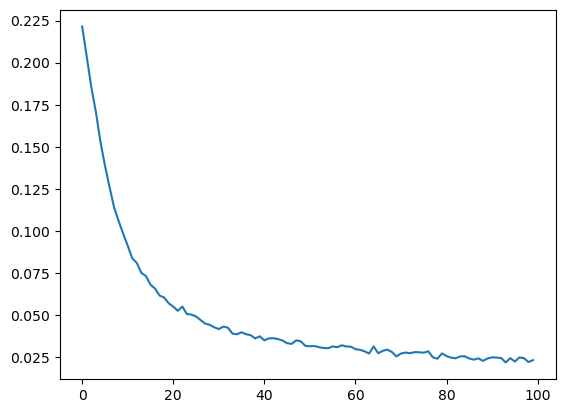

In [14]:
plt.plot(hist)
plt.show()

In [15]:
model.evaluate(test_x, test_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.023555264>

make tensorflow model to compare

In [16]:
tf_model = tf.keras.Sequential()
tf_model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=3, input_shape=train_x.shape[1::], activation='relu'))
tf_model.add(tf.keras.layers.Flatten())
tf_model.add(tf.keras.layers.Dense(32, activation='relu'))
tf_model.add(tf.keras.layers.Dense(10, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
tf_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [17]:
tf_model.evaluate(test_x, test_y)

313/313 [==============================] - 2s 6ms/step - loss: 2.3486


2.348562002182007

In [18]:
tf_hist = tf_model.fit(train_x, train_y, epochs=100, batch_size=4096, verbose=1)

Epoch 1/100
10/10 [==============================] - 1s 69ms/step - loss: 2.3216
Epoch 2/100
10/10 [==============================] - 1s 69ms/step - loss: 2.2713
Epoch 3/100
10/10 [==============================] - 1s 68ms/step - loss: 2.2243
Epoch 4/100
10/10 [==============================] - 1s 68ms/step - loss: 2.1752
Epoch 5/100
10/10 [==============================] - 1s 84ms/step - loss: 2.1215
Epoch 6/100
10/10 [==============================] - 1s 78ms/step - loss: 2.0631
Epoch 7/100
10/10 [==============================] - 1s 73ms/step - loss: 1.9994
Epoch 8/100
10/10 [==============================] - 1s 77ms/step - loss: 1.9311
Epoch 9/100
10/10 [==============================] - 1s 69ms/step - loss: 1.8596
Epoch 10/100
10/10 [==============================] - 1s 79ms/step - loss: 1.7858
Epoch 11/100
10/10 [==============================] - 1s 75ms/step - loss: 1.7110
Epoch 12/100
10/10 [==============================] - 1s 71ms/step - loss: 1.6372
Epoch 13/100
10/10 [=====

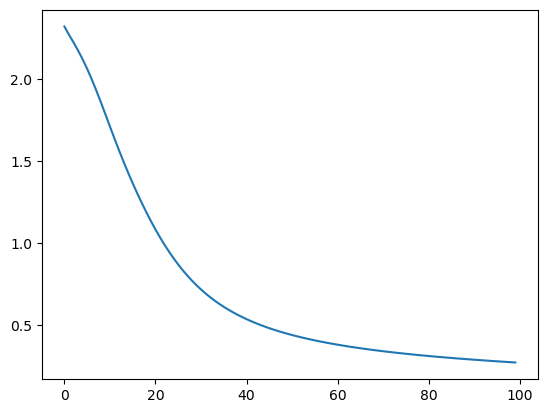

In [19]:
plt.plot(tf_hist.history['loss'])
plt.show()

In [20]:
tf_model.evaluate(test_x, test_y)

313/313 [==============================] - 1s 3ms/step - loss: 0.2626


0.26258742809295654